## Apply the Gaussian Mixture Models (GMM) Method to cluster the dataset
Author: Adrien Loiseau

In [1]:
# Run the help_functions.py script to have acces to the imports and helper functions
%run help_functions.py

##### Load the dataset containing the 500 hPa geopotential height data

In [2]:
file_name = "Data/ERA5_geopotential_500hPa_1940_2025_winter_midnight_Euro_Atlantic.nc"
dataset_dict = load_dataset(file_name=file_name)

years_array = np.arange(dataset_dict["first_year"], dataset_dict["last_year"]+1, 1)
winter_months = ["Dec", "Jan", "Feb"]

Geopotential height dataset (0.25°x0.25°): (nb_days=7731, nb_lats=241, nb_longs=561, grid_size=135201)
Geopotential height dataset (0.50°x0.50°): (nb_days=7731, nb_lats=121, nb_longs=281, grid_size=34001)
Geopotential height data: (7731, 121, 281)
Reshaped geopotential height data: (7731, 34001)
Geopotential height anomalies: (7731, 121, 281)
Reshaped geopotential height anomalies: (7731, 34001)
Daily winter data from 1940 to 2025 successfully loaded. Loading time: 53.28 seconds.


### Apply PCA to the geopotential height anomalies

In [4]:
nb_modes = 9
data_for_PCA = dataset_dict["geopotential_height_anomalies_reshaped"]

### Run PCA with nb_modes modes ###
start_time = time.time()
pca = PCA(n_components=nb_modes).fit(data_for_PCA)
end_time = time.time() ; print(f"PCA algorithm with {nb_modes} modes performed in {end_time-start_time:.2f} seconds.")

### Calculate the explained variance by the first nb_modes PCA modes ###
explained_variance = pca.explained_variance_ratio_ * 100
print(f"Total explained variance by the first {nb_modes} PCA modes: {explained_variance.sum():.2f}%")

### Transform the geopotential height anomalies using the PCA model (Project the data onto the first nb_modes PCA modes) ###
PCA_transformed_data = pca.transform(data_for_PCA)
print(f"Transformed geopotential height shape: {PCA_transformed_data.shape}")
print(f"Principal components shape: {pca.components_.shape}")

data_for_clustering = PCA_transformed_data

PCA algorithm with 9 modes performed in 5.48 seconds.
Total explained variance by the first 9 PCA modes: 76.09%
Transformed geopotential height shape: (7731, 9)
Principal components shape: (9, 34001)


### K-Means Clustering for comparison

In [5]:
nb_clusters = 4 ; n_init = 1000
start_time = time.time()
kmeans_4 = KMeans(n_clusters=nb_clusters, init="k-means++", n_init=n_init).fit(data_for_clustering) ; y_pred_kmeans_4 = kmeans_4.predict(data_for_clustering)
frequency_kmeans_4 = np.bincount(y_pred_kmeans_4) ; sorted_indices_kmeans_4 = np.argsort(frequency_kmeans_4)[::-1]
y_pred_sorted_kmeans_4 = np.array([np.argwhere(sorted_indices_kmeans_4 == i)[0][0] for i in y_pred_kmeans_4])
end_time = time.time() ; print(f"K-Means algorithm with {nb_clusters} clusters performed in {end_time-start_time:.2f} seconds.")

K-Means algorithm with 4 clusters performed in 17.23 seconds.


In [6]:
nb_clusters = 7 ; n_init = 1000
start_time = time.time()
kmeans_7 = KMeans(n_clusters=nb_clusters, init="k-means++", n_init=n_init).fit(data_for_clustering) ; y_pred_kmeans_7 = kmeans_7.predict(data_for_clustering)
frequency_kmeans_7 = np.bincount(y_pred_kmeans_7) ; sorted_indices_kmeans_7 = np.argsort(frequency_kmeans_7)[::-1]
y_pred_sorted_kmeans_7 = np.array([np.argwhere(sorted_indices_kmeans_7 == i)[0][0] for i in y_pred_kmeans_7])
end_time = time.time() ; print(f"K-Means algorithm with {nb_clusters} clusters performed in {end_time-start_time:.2f} seconds.")

K-Means algorithm with 7 clusters performed in 19.60 seconds.


In [7]:
nb_clusters = 8 ; n_init = 1000
start_time = time.time()
kmeans_8 = KMeans(n_clusters=nb_clusters, init="k-means++", n_init=n_init).fit(data_for_clustering) ; y_pred_kmeans_8 = kmeans_8.predict(data_for_clustering)
frequency_kmeans_8 = np.bincount(y_pred_kmeans_8) ; sorted_indices_kmeans_8 = np.argsort(frequency_kmeans_8)[::-1]
y_pred_sorted_kmeans_8 = np.array([np.argwhere(sorted_indices_kmeans_8 == i)[0][0] for i in y_pred_kmeans_8])
end_time = time.time() ; print(f"K-Means algorithm with {nb_clusters} clusters performed in {end_time-start_time:.2f} seconds.")

K-Means algorithm with 8 clusters performed in 25.15 seconds.


In [18]:
def plot_centroids(nb_clusters, cluster_centers, y_pred, method, cluster_names=None, savefig=False):
    nb_lats = len(dataset_dict["lats"]) ; nb_longs = len(dataset_dict["longs"])

    ### Project the cluster centers back to the original space ###
    centroids_original_space = (cluster_centers @ pca.components_).reshape(nb_clusters, nb_lats, nb_longs)

    ### Sort the clusters in descending order of their frequency of occurrence ###
    frequency_array = np.bincount(y_pred) / len(y_pred) * 100 ; sorted_indices = np.argsort(frequency_array)[::-1]

    ncols = 2 ; nrows = int(np.ceil(nb_clusters / ncols)) # ncols = 4
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*5, nrows*3+0.5), constrained_layout=True) # If save: nrows*3+0.5 - else: nrows*3+1

    for cluster_idx in range(nrows*ncols): # Loop over the cluster indices (starting from 0 --> +1)
        row = cluster_idx // ncols ; col = cluster_idx % ncols ; axis_to_plot = axs[col] if (nrows == 1) else axs[row, col]

        if (cluster_idx < nb_clusters):
            if cluster_names is not None: axis_to_plot.set_title(f"Centroid {cluster_idx+1}: {cluster_names[cluster_idx]} ({frequency_array[sorted_indices[cluster_idx]]:.1f}%)", fontsize=20)
            else: axis_to_plot.set_title(f"Centroid {cluster_idx+1} ({frequency_array[sorted_indices[cluster_idx]]:.2f}%)", fontsize=20)
            ### Create the contour plot ###
            m, contour, ticks = create_contour_data(ax=axis_to_plot, dataset_dict=dataset_dict, type_plot="geopotential_height_anomalies_temporal_mean",
                                                    geopotential_height_data_to_plot=(centroids_original_space[sorted_indices[cluster_idx], :]), weather_regime=True)
        else: axis_to_plot.set_visible(False)

    # fig.suptitle(f"Centroids {method} ({nb_clusters} clusters)", fontsize=20)
    cbar = fig.colorbar(contour, ax=axs, ticks=ticks, location='bottom', extend='both', shrink=0.75, pad=0.02, aspect=40)
    cbar.ax.tick_params(axis="x", labelsize=15, length=7.5, width=1)
    cbar.ax.text(x=1.1, y=-1.25, s=r'$[m]$', transform=cbar.ax.transAxes, ha='center', va='center', fontsize=15) # If save: y=-1.25 - else: y=-0.5
    if (savefig == True): plt.savefig(f"Images/GMMs_{nb_clusters}_centroids_PCA_{dataset_dict['first_year']}_{dataset_dict['last_year']}.png", dpi=300, bbox_inches="tight")
    plt.show()

---
## Four clusters
---

In [9]:
nb_clusters = 4 ; n_init = 1000
start_time = time.time()
gmm_full_4 = GaussianMixture(n_components=nb_clusters, n_init=n_init, covariance_type="full").fit(data_for_clustering) ; y_pred_gmm_full_4 = gmm_full_4.predict(data_for_clustering)
frequency_gmm_full_4 = np.bincount(y_pred_gmm_full_4) ; sorted_indices_gmm_full_4 = np.argsort(frequency_gmm_full_4)[::-1]
y_pred_sorted_gmm_full_4 = np.array([np.argwhere(sorted_indices_gmm_full_4 == i)[0][0] for i in y_pred_gmm_full_4])
end_time = time.time() ; print(f"GMM full algorithm with {nb_clusters} clusters performed in {end_time-start_time:.2f} seconds.")

GMM full algorithm with 4 clusters performed in 107.41 seconds.


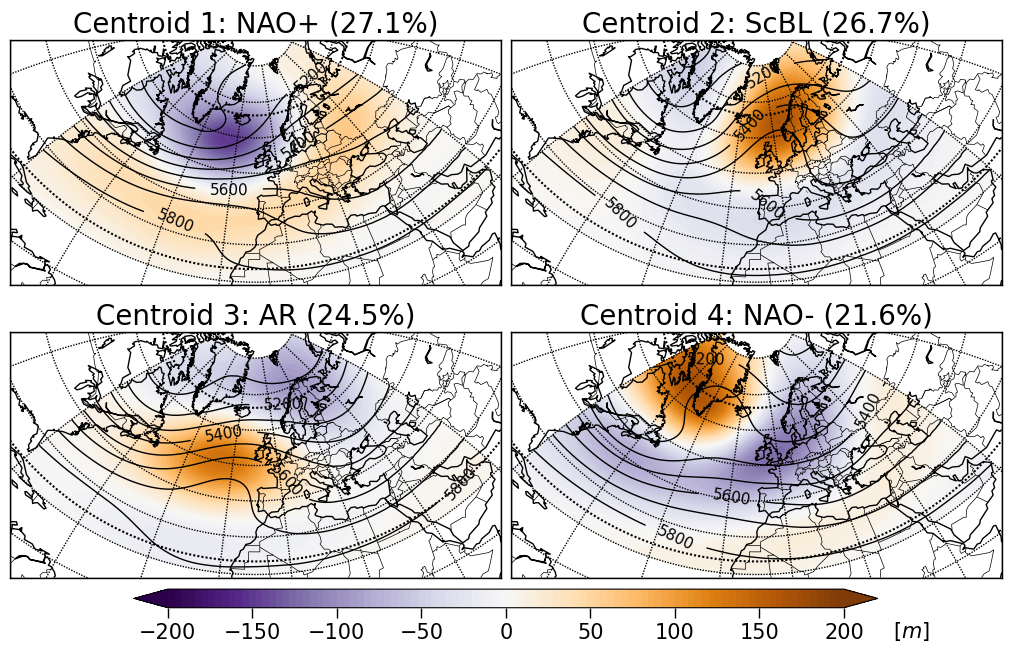

In [19]:
cluster_names_gmm_full_4 = ["NAO+", "ScBL", "AR", "NAO-"]
plot_centroids(nb_clusters=len(cluster_names_gmm_full_4), cluster_centers=gmm_full_4.means_, y_pred=y_pred_gmm_full_4, method="GMM (full)", cluster_names=cluster_names_gmm_full_4, savefig=False)

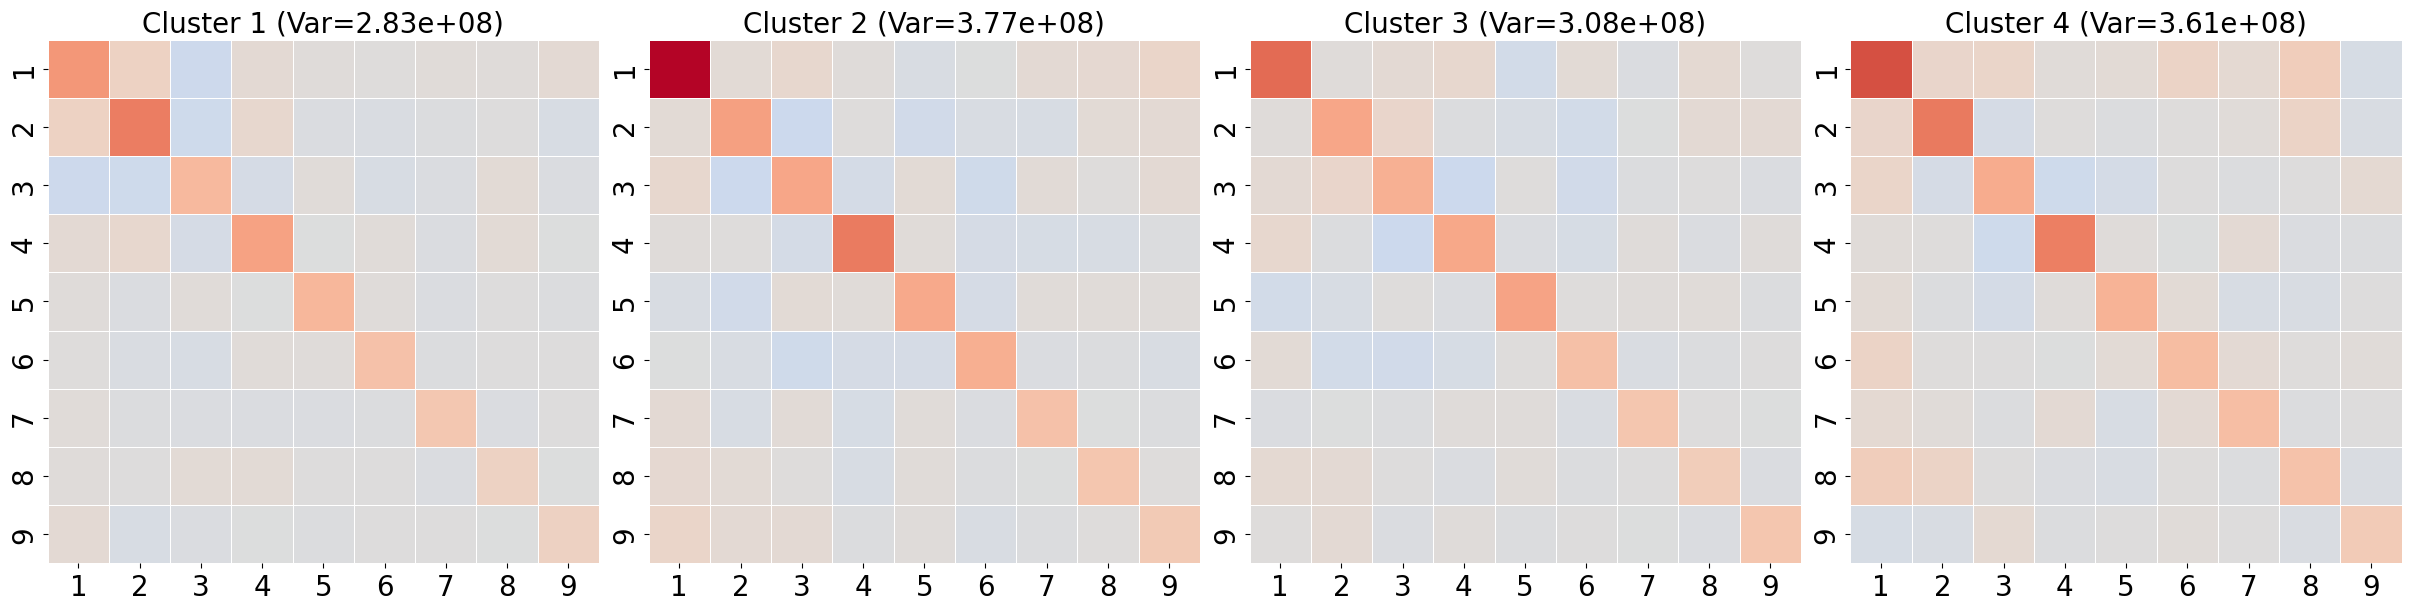

In [11]:
nb_clusters = 4 ; nb_modes_to_keep = 9 ; heatmap_labels = np.arange(nb_modes_to_keep) + 1
ncols = 4 ; nrows = int(np.ceil(nb_clusters / ncols)) ; fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*6, nrows*6), constrained_layout=True)
covariance_matrix = np.zeros((nb_clusters, nb_modes_to_keep, nb_modes_to_keep)) ; variance_array = np.zeros(nb_clusters)
for cluster_idx in range(nb_clusters):
    cluster_data = data_for_clustering[y_pred_sorted_gmm_full_4 == cluster_idx]
    covariance_matrix[cluster_idx] = np.cov(cluster_data, rowvar=False)[:nb_modes_to_keep, :nb_modes_to_keep]
    variance_array[cluster_idx] = np.var(cluster_data, axis=0).sum()
covariance_matrix /= 1e7

for cluster_idx in range(nb_clusters):
    axis_to_plot = axs[cluster_idx % ncols] if (nrows == 1) else axs[cluster_idx // ncols, cluster_idx % ncols]
    axis_to_plot.set_title(f"Cluster {cluster_idx+1} (Var={variance_array[cluster_idx]:.3g})", fontsize=20)
    sns.heatmap(covariance_matrix[cluster_idx], annot=False, fmt=".1f", cmap="coolwarm", linewidths=0.5, center=0, cbar=False, vmin=np.min(covariance_matrix), vmax=np.max(covariance_matrix), ax=axis_to_plot, xticklabels=heatmap_labels, yticklabels=heatmap_labels, annot_kws={"fontsize":15})
    axis_to_plot.tick_params(labelsize=20)
plt.show()

---
## Seven clusters
---

In [12]:
nb_clusters = 7 ; n_init = 1000
start_time = time.time()
gmm_full_7 = GaussianMixture(n_components=nb_clusters, n_init=n_init, covariance_type="full").fit(data_for_clustering) ; y_pred_gmm_full_7 = gmm_full_7.predict(data_for_clustering)
frequency_gmm_full_7 = np.bincount(y_pred_gmm_full_7) ; sorted_indices_gmm_full_7 = np.argsort(frequency_gmm_full_7)[::-1]
y_pred_sorted_gmm_full_7 = np.array([np.argwhere(sorted_indices_gmm_full_7 == i)[0][0] for i in y_pred_gmm_full_7])
end_time = time.time() ; print(f"K-Means algorithm with {nb_clusters} clusters performed in {end_time-start_time:.2f} seconds.")

K-Means algorithm with 7 clusters performed in 196.67 seconds.


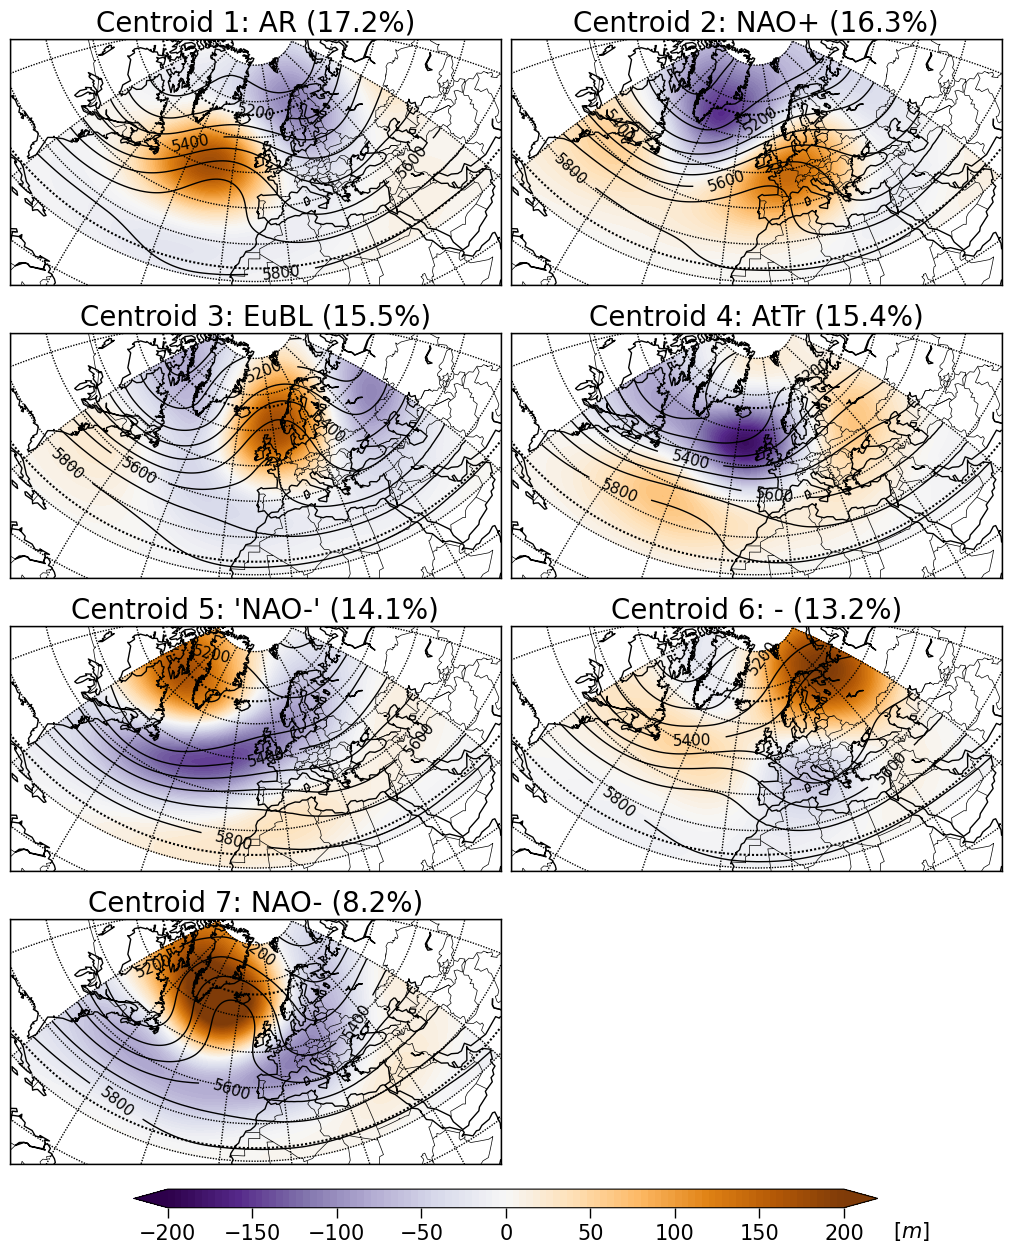

In [24]:
cluster_names_gmm_full_7 = ["AR", "NAO+", "EuBL", "AtTr", "\'NAO-\'", "-", "NAO-"]
plot_centroids(nb_clusters=len(cluster_names_gmm_full_7), cluster_centers=gmm_full_7.means_, y_pred=y_pred_gmm_full_7, method="GMM (full)", cluster_names=cluster_names_gmm_full_7, savefig=False)

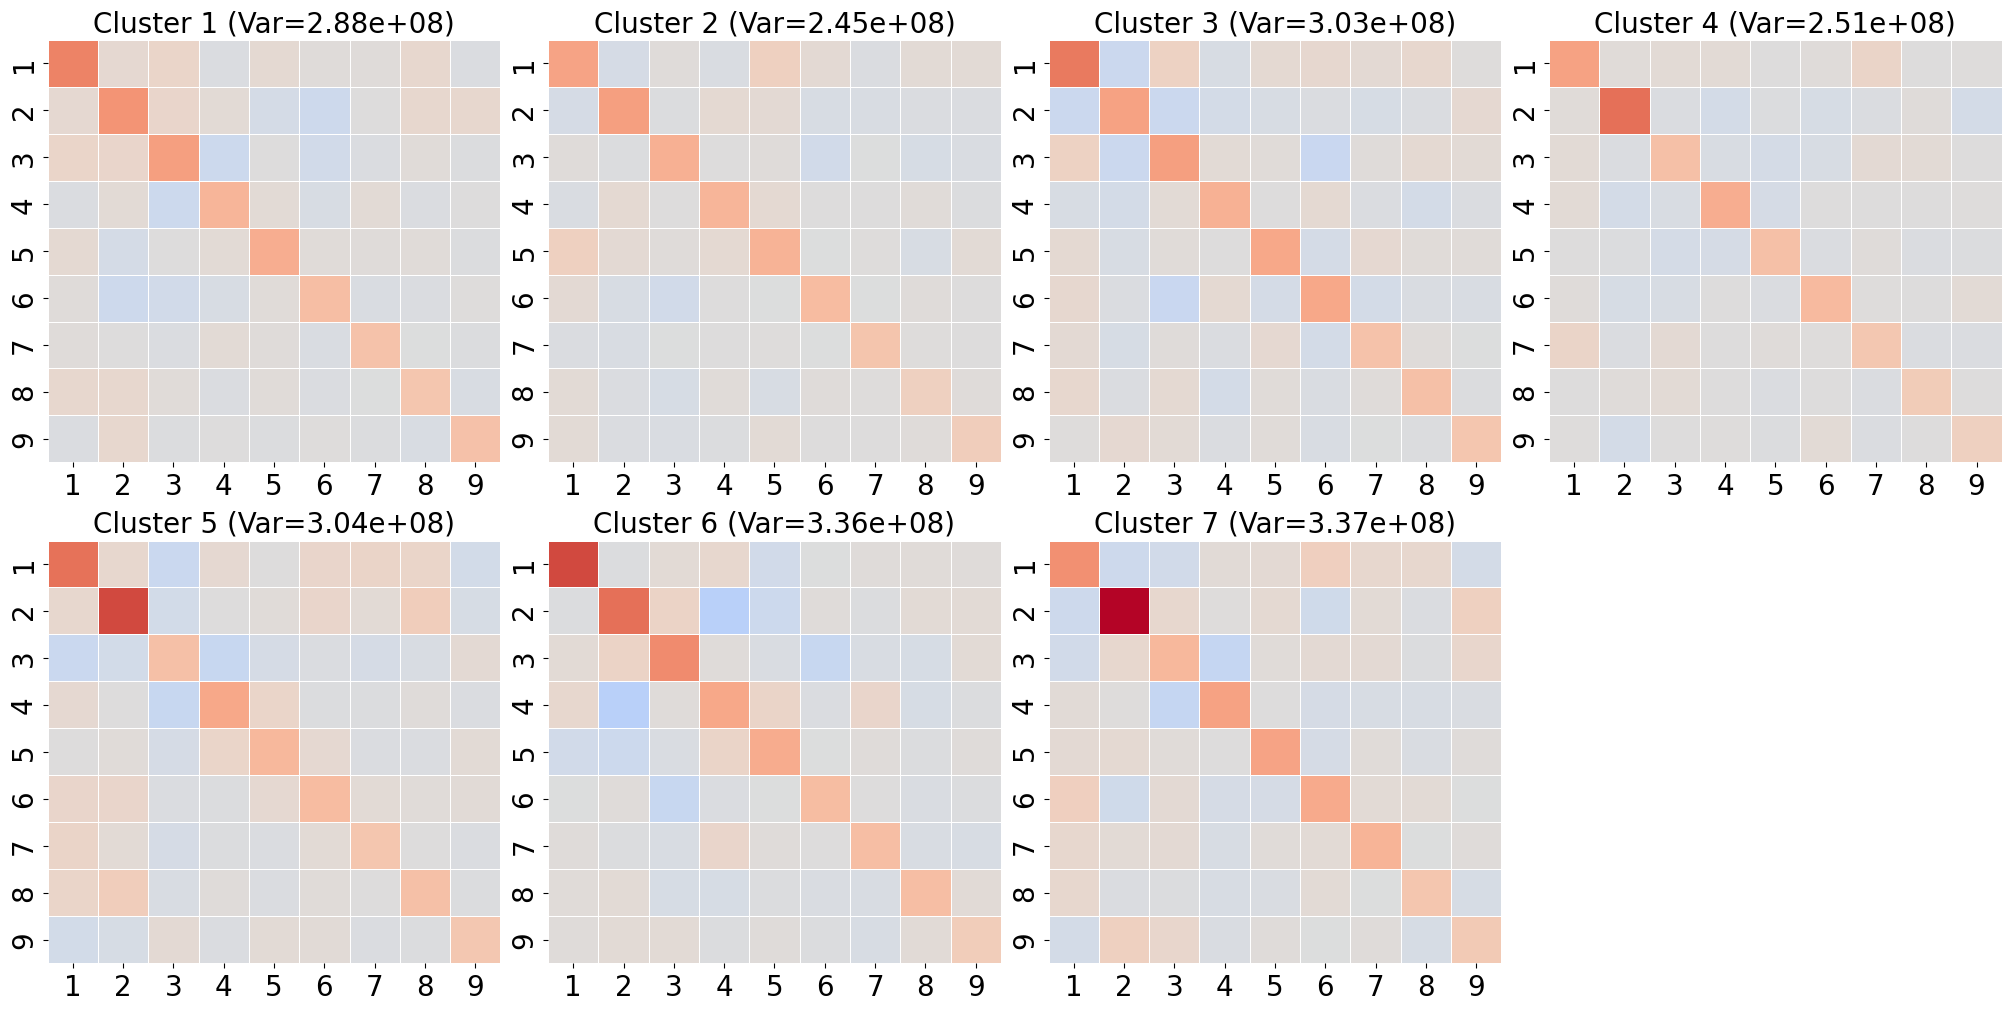

In [14]:
nb_clusters = 7 ; nb_modes_to_keep = 9 ; heatmap_labels = np.arange(nb_modes_to_keep) + 1
ncols = 4 ; nrows = int(np.ceil(nb_clusters / ncols)) ; fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*5, nrows*5), constrained_layout=True)
covariance_matrix = np.zeros((nb_clusters, nb_modes_to_keep, nb_modes_to_keep)) ; variance_array = np.zeros(nb_clusters)
for cluster_idx in range(nb_clusters):
    cluster_data = data_for_clustering[y_pred_sorted_gmm_full_7 == cluster_idx]
    covariance_matrix[cluster_idx] = np.cov(cluster_data, rowvar=False)[:nb_modes_to_keep, :nb_modes_to_keep]
    variance_array[cluster_idx] = np.var(cluster_data, axis=0).sum()
covariance_matrix /= 1e7

for cluster_idx in range(nrows*ncols):
    axis_to_plot = axs[cluster_idx % ncols] if (nrows == 1) else axs[cluster_idx // ncols, cluster_idx % ncols]
    if (cluster_idx >= nb_clusters): axis_to_plot.set_visible(False) ; continue
    axis_to_plot.set_title(f"Cluster {cluster_idx+1} (Var={variance_array[cluster_idx]:.3g})", fontsize=20)
    sns.heatmap(covariance_matrix[cluster_idx], annot=False, fmt=".1f", cmap="coolwarm", linewidths=0.5, center=0, cbar=False, vmin=np.min(covariance_matrix), vmax=np.max(covariance_matrix), ax=axis_to_plot, xticklabels=heatmap_labels, yticklabels=heatmap_labels, annot_kws={"fontsize":15})
    axis_to_plot.tick_params(labelsize=20)
plt.show()

---
## Eight clusters
---

In [15]:
nb_clusters = 8 ; n_init = 1000
start_time = time.time()
gmm_full_8 = GaussianMixture(n_components=nb_clusters, n_init=n_init, covariance_type="full").fit(data_for_clustering) ; y_pred_gmm_full_8 = gmm_full_8.predict(data_for_clustering)
frequency_gmm_full_8 = np.bincount(y_pred_gmm_full_8) ; sorted_indices_gmm_full_8 = np.argsort(frequency_gmm_full_8)[::-1]
y_pred_sorted_gmm_full_8 = np.array([np.argwhere(sorted_indices_gmm_full_8 == i)[0][0] for i in y_pred_gmm_full_8])
end_time = time.time() ; print(f"K-Means algorithm with {nb_clusters} clusters performed in {end_time-start_time:.2f} seconds.")

K-Means algorithm with 8 clusters performed in 259.32 seconds.


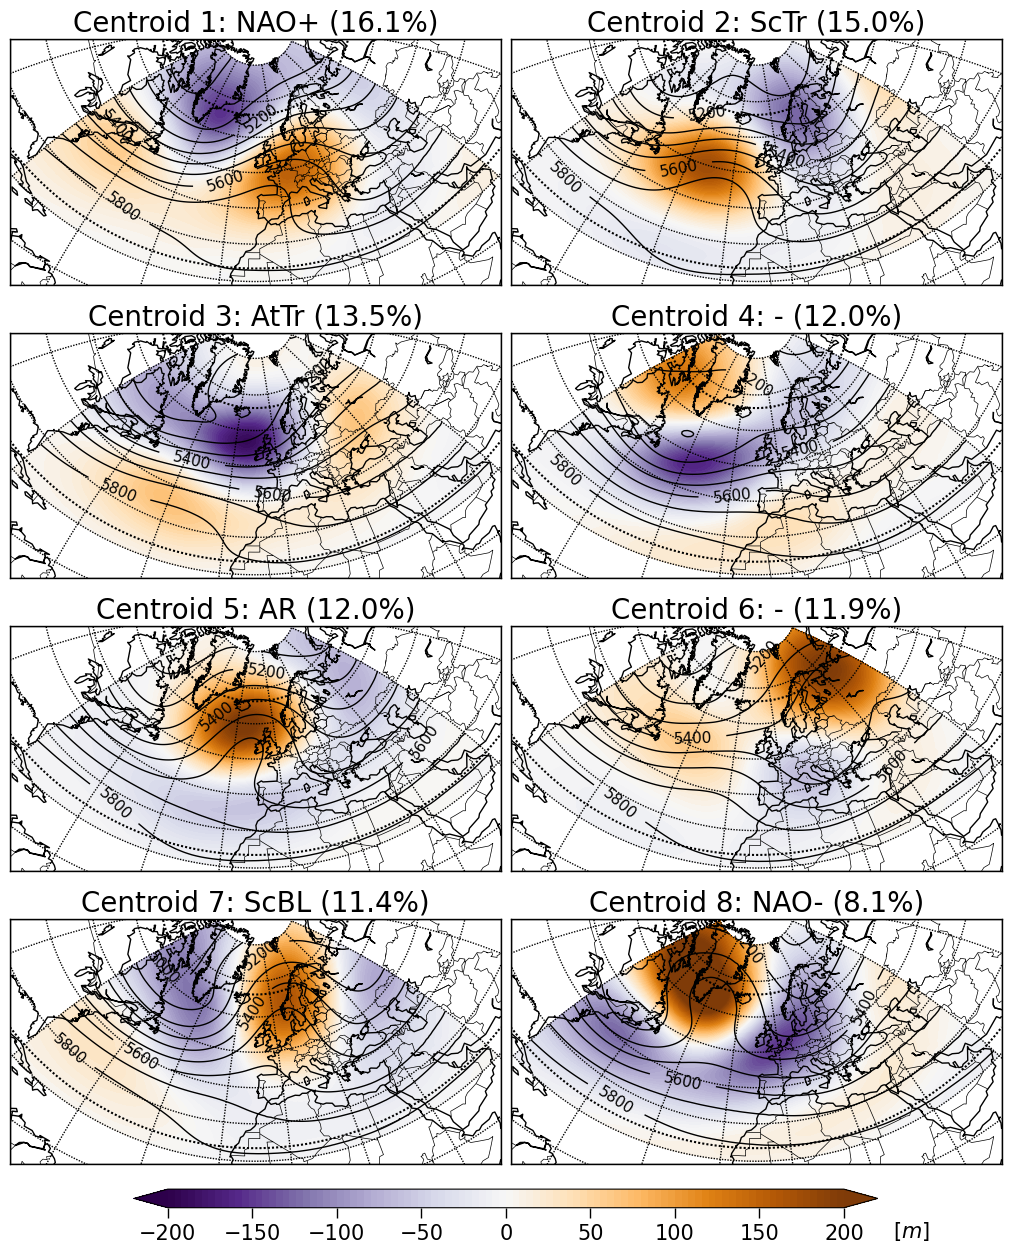

In [25]:
cluster_names_gmm_full_8 = ["NAO+", "ScTr", "AtTr", "-", "AR", "-", "ScBL", "NAO-"]
plot_centroids(nb_clusters=len(cluster_names_gmm_full_8), cluster_centers=gmm_full_8.means_, y_pred=y_pred_gmm_full_8, method="GMM (full)", cluster_names=cluster_names_gmm_full_8, savefig=False)

---
## GMM Analysis
---

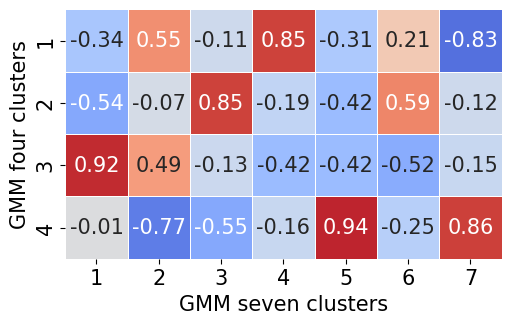

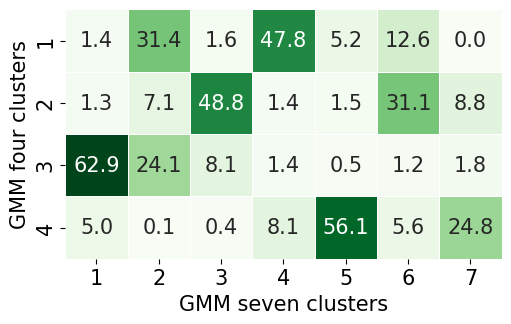

In [17]:
nb_clusters_gmm_full_4 = 4 ; nb_clusters_gmm_full_7 = 7

# Correlation between the centroids of the GMM 4 and GMM 7 clusters
correlation_GMM_4_vs_7 = np.zeros((nb_clusters_gmm_full_4, nb_clusters_gmm_full_7))
number_of_similar_predictions = np.zeros((nb_clusters_gmm_full_4, nb_clusters_gmm_full_7))
for i in range(nb_clusters_gmm_full_4):
    for j in range(nb_clusters_gmm_full_7):
        correlation_GMM_4_vs_7[i, j] = np.corrcoef(gmm_full_4.means_[sorted_indices_gmm_full_4[i], :].flatten(), gmm_full_7.means_[sorted_indices_gmm_full_7[j], :].flatten())[0, 1]
        ### Count number of samples within cluster i of GMM full 4 and j of GMM full 7 ###
        mask = (y_pred_sorted_gmm_full_4 == i) & (y_pred_sorted_gmm_full_7 == j) ; count = np.sum(mask) ; number_of_similar_predictions[i, j] = count / np.sum(y_pred_sorted_gmm_full_4 == i) * 100

fig, axs = plt.subplots(1, 1, figsize=(5, 4), constrained_layout=True)
sns.heatmap(correlation_GMM_4_vs_7, annot=True, fmt=".2f", cmap="coolwarm", cbar=False, ax=axs, square=True, linewidths=0.5, center=0, vmin=-1, vmax=1, annot_kws={"fontsize":15})
axs.set_xlabel("GMM seven clusters", fontsize=15) ; axs.set_ylabel("GMM four clusters", fontsize=15)
axs.set_xticklabels(np.arange(nb_clusters_gmm_full_7)+1, fontsize=15) ; axs.set_yticklabels(np.arange(nb_clusters_gmm_full_4)+1, fontsize=15)
# plt.savefig("Images/GMMs_4_vs_7_correlation.png", dpi=300, bbox_inches="tight")
plt.show()

fig, axs = plt.subplots(1, 1, figsize=(5, 4), constrained_layout=True)
sns.heatmap(number_of_similar_predictions, annot=True, fmt=".1f", cmap="Greens", cbar=False, ax=axs, square=True, linewidths=0.5, vmin=0, vmax=np.max(number_of_similar_predictions), annot_kws={"fontsize":15})
axs.set_xlabel("GMM seven clusters", fontsize=15) ; axs.set_ylabel("GMM four clusters", fontsize=15)
axs.set_xticklabels(np.arange(nb_clusters_gmm_full_7)+1, fontsize=15) ; axs.set_yticklabels(np.arange(nb_clusters_gmm_full_4)+1, fontsize=15)
# plt.savefig("Images/GMMs_4_vs_7_number_of_similar_predictions.png", dpi=300, bbox_inches="tight")
plt.show()

---
## GMM vs K-Means
---

In [50]:
def correlation_matrix_KMeans_GMM(kmeans, gmm, nb_clusters_kmeans, nb_clusters_gmm, sorted_indices_kmeans, sorted_indices_gmm, y_pred_sorted_kmeans, y_pred_sorted_gmm):
    # Correlation between the centroids of the different clustering methods
    correlation_KMeans_GMM = np.zeros((nb_clusters_gmm, nb_clusters_kmeans))
    number_of_similar_predictions = np.zeros_like(correlation_KMeans_GMM)
    mapping = np.zeros(nb_clusters_kmeans, dtype=int)
    for i in range(nb_clusters_gmm):
        for j in range(nb_clusters_kmeans):
            correlation_KMeans_GMM[i, j] = np.corrcoef(gmm_full.means_[sorted_indices_gmm[i], :].flatten(), kmeans.cluster_centers_[sorted_indices_kmeans[j], :].flatten())[0, 1]
            mask = (y_pred_sorted_gmm == i) & (y_pred_sorted_kmeans == j) ; count = np.sum(mask) ; number_of_similar_predictions[i, j] = count / np.sum(y_pred_sorted_gmm == i) * 100
        mapping[i] = np.argmax(correlation_KMeans_GMM[i, :])

    new_y_pred_sorted_gmm = np.array([mapping[i] for i in y_pred_sorted_gmm])
    print(f"Number of similar predictions: {np.sum(new_y_pred_sorted_gmm == y_pred_sorted_kmeans) / len(y_pred_sorted_kmeans) * 100:.2f}%")

    fig, axs = plt.subplots(1, 1, figsize=(nb_clusters_kmeans - 1, nb_clusters_gmm - 1), constrained_layout=True)
    sns.heatmap(correlation_KMeans_GMM, annot=True, fmt=".2f", cmap="coolwarm", cbar=False, ax=axs, square=True, linewidths=0.5, center=0, vmin=-1, vmax=1, annot_kws={"fontsize":15})
    axs.set_xlabel("K-Means", fontsize=15) ; axs.set_ylabel("GMM", fontsize=15)
    axs.set_xticklabels(np.arange(nb_clusters_kmeans)+1, fontsize=15) ; axs.set_yticklabels(np.arange(nb_clusters_gmm)+1, fontsize=15)
    # plt.savefig(f"Images/KMeans_{nb_clusters_kmeans}_vs_GMM_{nb_clusters_gmm}_correlation.png", dpi=300, bbox_inches="tight")
    plt.show()

    fig, axs = plt.subplots(1, 1, figsize=(nb_clusters_kmeans - 1, nb_clusters_gmm - 1), constrained_layout=True)
    sns.heatmap(number_of_similar_predictions, annot=True, fmt=".1f", cmap="Greens", cbar=False, ax=axs, square=True, linewidths=0.5, vmin=0, vmax=np.max(number_of_similar_predictions), annot_kws={"fontsize":15})
    axs.set_xlabel("K-Means", fontsize=15) ; axs.set_ylabel("GMM", fontsize=15)
    axs.set_xticklabels(np.arange(nb_clusters_kmeans)+1, fontsize=15) ; axs.set_yticklabels(np.arange(nb_clusters_gmm)+1, fontsize=15)
    # plt.savefig(f"Images/KMeans_{nb_clusters_kmeans}_vs_GMM_{nb_clusters_gmm}_number_of_similar_predictions.png", dpi=300, bbox_inches="tight")
    plt.show()

### Comparison GMM 4 vs K-Means 4 ###

70.38% of the predictions are similar
Number of similar predictions: 70.38%


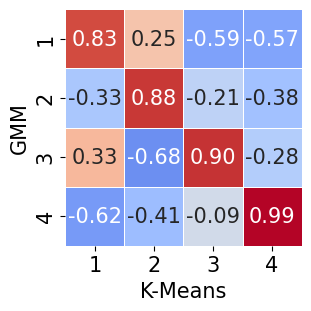

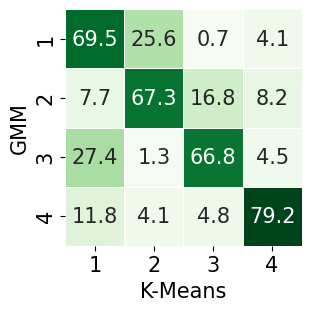

In [51]:
print(f"{np.sum(np.equal(y_pred_sorted_kmeans_4, y_pred_sorted_gmm_full_4)) / len(y_pred_sorted_kmeans_4) * 100:.2f}% of the predictions are similar")

nb_clusters_kmeans = len(np.unique(y_pred_sorted_kmeans_4)) ; nb_clusters_gmm = len(np.unique(y_pred_sorted_gmm_full_4))
kmeans = kmeans_4 ; gmm_full = gmm_full_4
sorted_indices_kmeans = sorted_indices_kmeans_4 ; sorted_indices_gmm = sorted_indices_gmm_full_4
correlation_matrix_KMeans_GMM(kmeans=kmeans, gmm=gmm_full, nb_clusters_kmeans=nb_clusters_kmeans, nb_clusters_gmm=nb_clusters_gmm, 
sorted_indices_kmeans=sorted_indices_kmeans, sorted_indices_gmm=sorted_indices_gmm, y_pred_sorted_kmeans=y_pred_sorted_kmeans_4, y_pred_sorted_gmm=y_pred_sorted_gmm_full_4)

### Comparison GMM 4 - K-Means 7 ###

Number of similar predictions: 46.20%


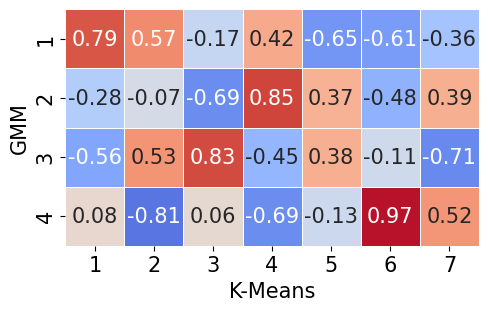

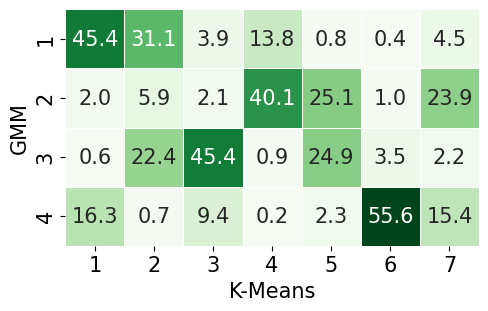

In [52]:
nb_clusters_gmm = len(np.unique(y_pred_sorted_gmm_full_4)) ; nb_clusters_kmeans = len(np.unique(y_pred_sorted_kmeans_7))
gmm_full = gmm_full_4 ; kmeans = kmeans_7
sorted_indices_gmm = sorted_indices_gmm_full_4 ; sorted_indices_kmeans = sorted_indices_kmeans_7
correlation_matrix_KMeans_GMM(kmeans=kmeans, gmm=gmm_full, nb_clusters_kmeans=nb_clusters_kmeans, nb_clusters_gmm=nb_clusters_gmm, sorted_indices_kmeans=sorted_indices_kmeans, \
                              sorted_indices_gmm=sorted_indices_gmm, y_pred_sorted_kmeans=y_pred_sorted_kmeans_7, y_pred_sorted_gmm=y_pred_sorted_gmm_full_4)

### Comparison GMM 7 - K-Means 7 ###

Number of similar predictions: 56.82%


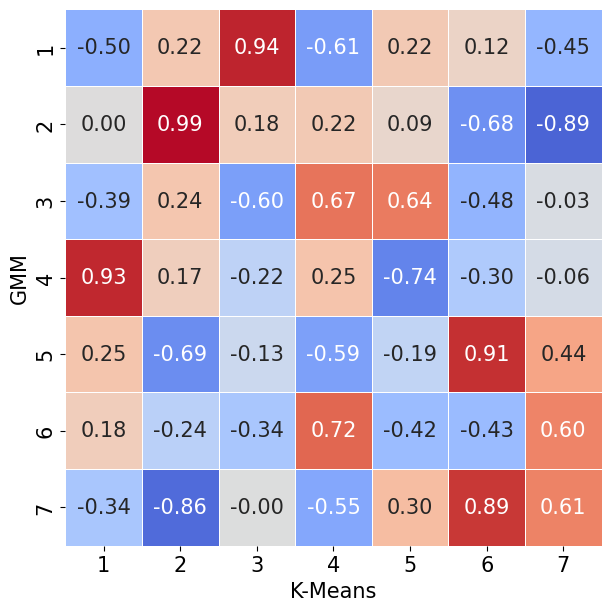

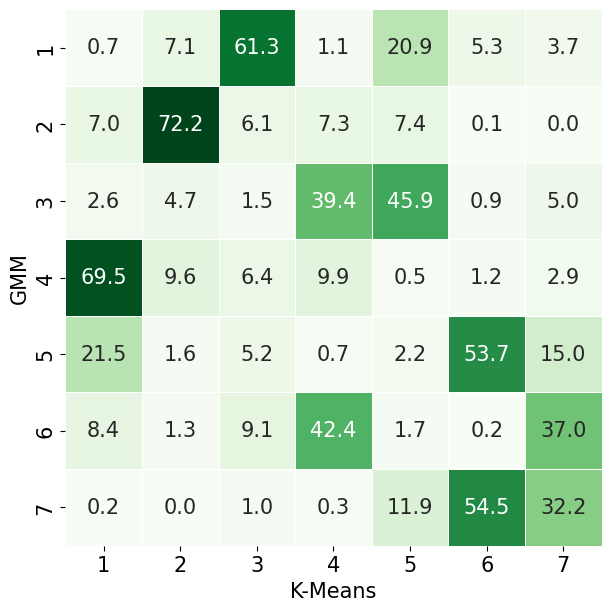

In [53]:
nb_clusters_gmm = len(np.unique(y_pred_sorted_gmm_full_7)) ; nb_clusters_kmeans = len(np.unique(y_pred_sorted_kmeans_7))
gmm_full = gmm_full_7 ; kmeans = kmeans_7
sorted_indices_gmm = sorted_indices_gmm_full_7 ; sorted_indices_kmeans = sorted_indices_kmeans_7
correlation_matrix_KMeans_GMM(kmeans=kmeans, gmm=gmm_full, nb_clusters_kmeans=nb_clusters_kmeans, nb_clusters_gmm=nb_clusters_gmm, sorted_indices_kmeans=sorted_indices_kmeans, \
                              sorted_indices_gmm=sorted_indices_gmm, y_pred_sorted_kmeans=y_pred_sorted_kmeans_7, y_pred_sorted_gmm=y_pred_sorted_gmm_full_7)

Number of similar predictions: 56.93%


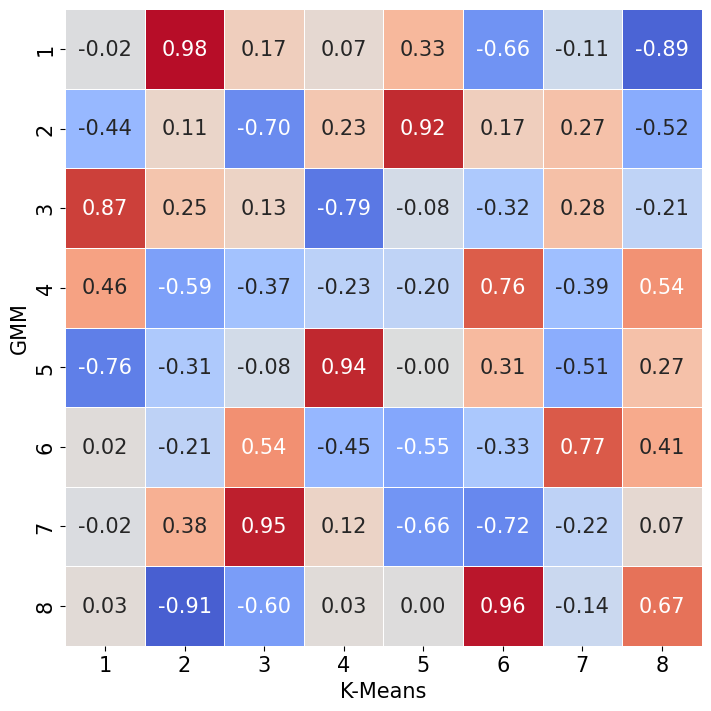

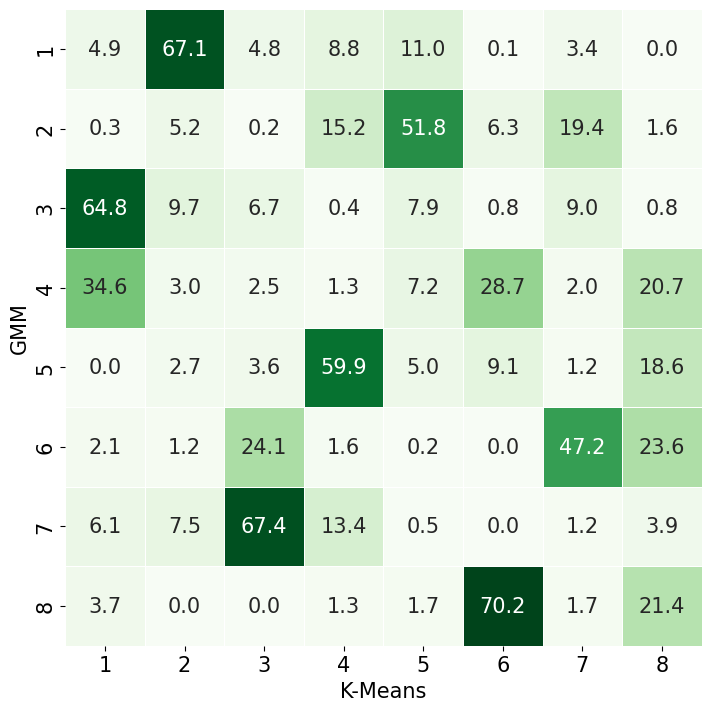

In [54]:
nb_clusters_gmm = len(np.unique(y_pred_sorted_gmm_full_8)) ; nb_clusters_kmeans = len(np.unique(y_pred_sorted_kmeans_8))
gmm_full = gmm_full_8 ; kmeans = kmeans_8
sorted_indices_gmm = sorted_indices_gmm_full_8 ; sorted_indices_kmeans = sorted_indices_kmeans_8
correlation_matrix_KMeans_GMM(kmeans=kmeans, gmm=gmm_full, nb_clusters_kmeans=nb_clusters_kmeans, nb_clusters_gmm=nb_clusters_gmm, sorted_indices_kmeans=sorted_indices_kmeans, \
                              sorted_indices_gmm=sorted_indices_gmm, y_pred_sorted_kmeans=y_pred_sorted_kmeans_8, y_pred_sorted_gmm=y_pred_sorted_gmm_full_8)

---
## Link with the temperature in Brussels
---

In [56]:
def plot_temperature_per_cluster(avg_temperature, min_temperature, max_temperature, cluster_names):
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 3.5), constrained_layout=True)
    ax = sns.heatmap(avg_temperature, annot=True, cmap='OrRd', cbar=True, annot_kws={"size":15}, linewidth=0.5, fmt=".1f", vmin=np.min(avg_temperature), vmax=np.max(avg_temperature), xticklabels=cluster_names, yticklabels=winter_months, ax=axs[0])
    axs[0].set_title("Average temperature [°C]", fontsize=15) ; axs[0].set_xlabel("Weather Regime", fontsize=15) ; axs[0].set_ylabel("Month", fontsize=15) ; axs[0].tick_params(labelsize=13)
    cbar_ax = ax.figure.axes[-1] ; cbar_ax.tick_params(labelsize=13)

    ax = sns.heatmap(min_temperature, annot=True, cmap='Blues', cbar=True, fmt=".1f", annot_kws={"size":15}, linewidth=0.5, vmin=np.min(min_temperature), vmax=np.max(min_temperature), xticklabels=cluster_names, yticklabels=winter_months, ax=axs[1])
    axs[1].set_title("Minimum temperature [°C]", fontsize=15) ; axs[1].set_xlabel("Weather Regime", fontsize=15) ; axs[1].set_ylabel("Month", fontsize=15) ; axs[1].tick_params(labelsize=13)
    cbar_ax = ax.figure.axes[-1] ; cbar_ax.tick_params(labelsize=13)

    ax = sns.heatmap(max_temperature, annot=True, cmap='Reds', cbar=True, fmt=".1f", annot_kws={"size":15}, linewidth=0.5, vmin=np.min(max_temperature), vmax=np.max(max_temperature), xticklabels=cluster_names, yticklabels=winter_months, ax=axs[2])
    axs[2].set_title("Maximum temperature [°C]", fontsize=15) ; axs[2].set_xlabel("Weather Regime", fontsize=15) ; axs[2].set_ylabel("Month", fontsize=15) ; axs[2].tick_params(labelsize=13)
    cbar_ax = ax.figure.axes[-1] ; cbar_ax.tick_params(labelsize=13)
    plt.show()

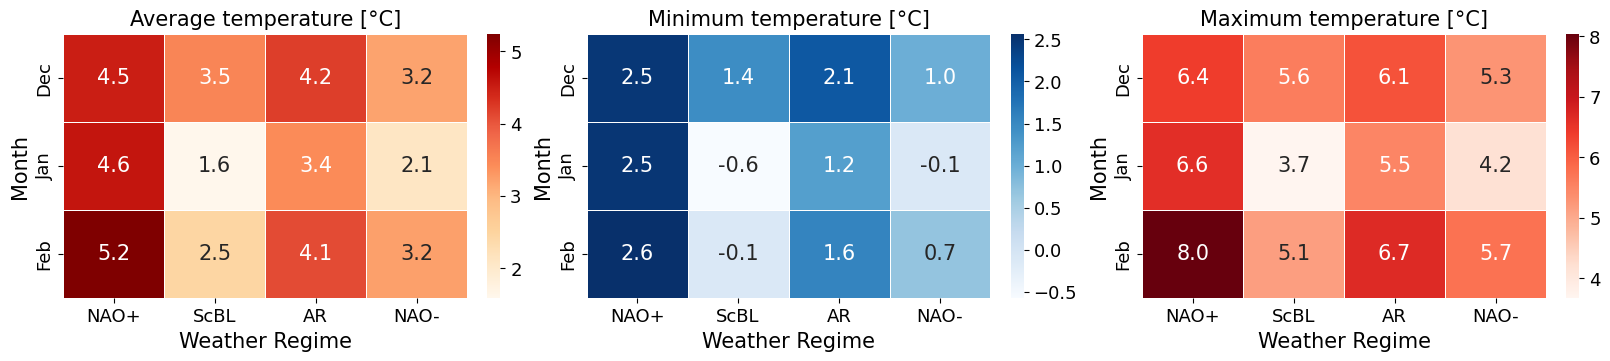

In [57]:
nb_clusters = 4 ; cluster_names = cluster_names_gmm_full_4 ; y_pred_sorted = y_pred_sorted_gmm_full_4
avg_temperature, min_temperature, max_temperature, number_of_days_with_temperature = retrieve_temperature_data_for_clusters(y_pred=y_pred_sorted, nb_clusters=nb_clusters, dataset_dict=dataset_dict)
avg_temperature = plot_temperature_per_cluster(avg_temperature=avg_temperature, min_temperature=min_temperature, max_temperature=max_temperature, cluster_names=cluster_names)

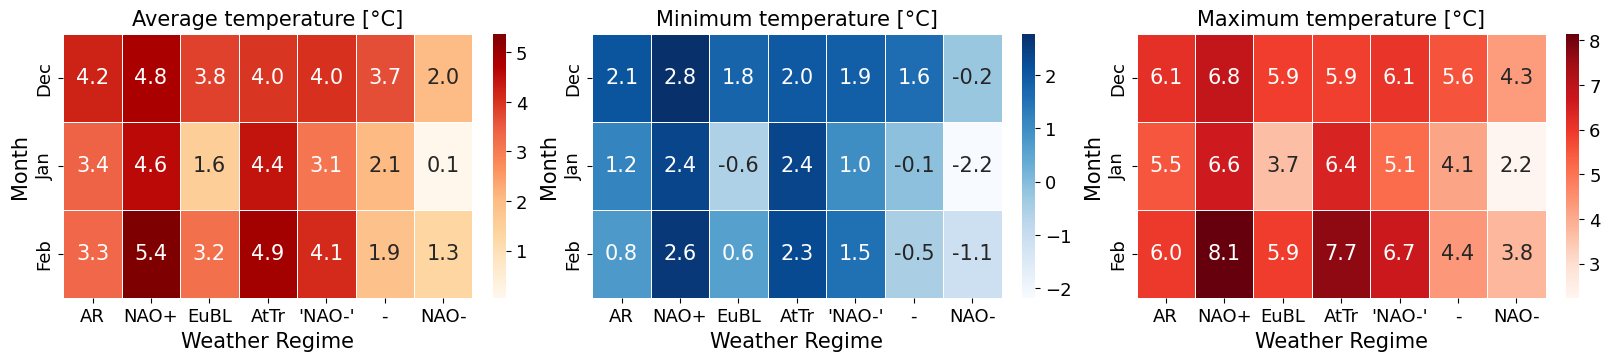

In [58]:
nb_clusters = 7 ; cluster_names = cluster_names_gmm_full_7 ; y_pred_sorted = y_pred_sorted_gmm_full_7
avg_temperature, min_temperature, max_temperature, number_of_days_with_temperature = retrieve_temperature_data_for_clusters(y_pred=y_pred_sorted, nb_clusters=nb_clusters, dataset_dict=dataset_dict)
plot_temperature_per_cluster(avg_temperature=avg_temperature, min_temperature=min_temperature, max_temperature=max_temperature, cluster_names=cluster_names)

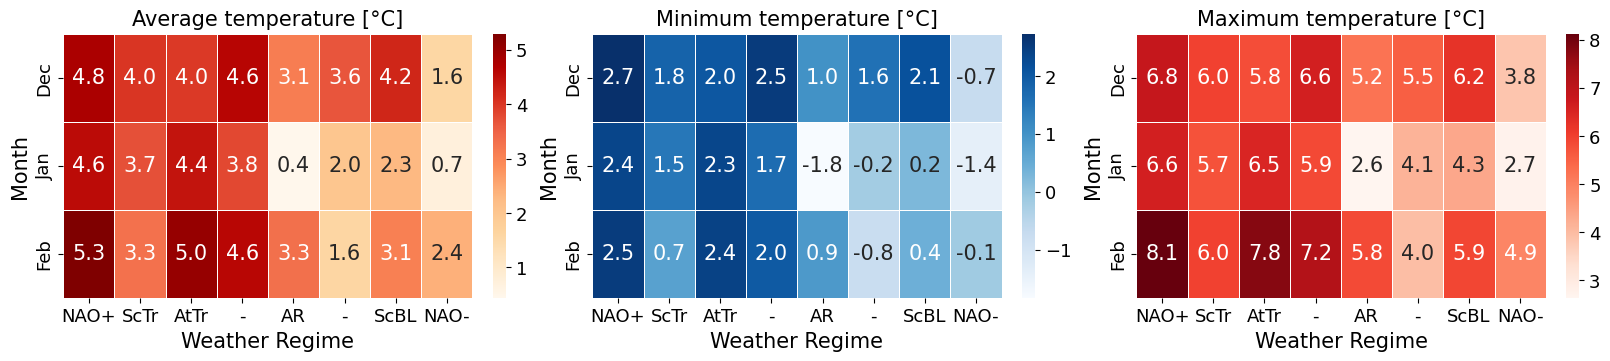

In [59]:
nb_clusters = 8 ; cluster_names = cluster_names_gmm_full_8 ; y_pred_sorted = y_pred_sorted_gmm_full_8
avg_temperature, min_temperature, max_temperature, number_of_days_with_temperature = retrieve_temperature_data_for_clusters(y_pred=y_pred_sorted, nb_clusters=nb_clusters, dataset_dict=dataset_dict)
plot_temperature_per_cluster(avg_temperature=avg_temperature, min_temperature=min_temperature, max_temperature=max_temperature, cluster_names=cluster_names)

---
## Number of PCs Analysis
---

In [15]:
def apply_PCA_GMM(nb_modes, nb_clusters, n_init, verbose=False):
    data_for_PCA = dataset_dict["geopotential_height_anomalies_reshaped"]
    start_time = time.time()
    pca = PCA(n_components=nb_modes).fit(data_for_PCA)
    end_time = time.time()
    if (verbose == True): print(f"PCA algorithm with {nb_modes} modes performed in {end_time-start_time:.2f} seconds.")

    explained_variance = pca.explained_variance_ratio_ * 100
    if (verbose == True): print(f"Total explained variance by the first {nb_modes} PCA modes: {explained_variance.sum():.2f}%")

    ### Transform the geopotential height anomalies using the PCA model (Project the data onto the first nb_modes PCA modes) ###
    PCA_transformed_data = pca.transform(data_for_PCA)
    if (verbose == True): 
        print(f"Transformed geopotential height shape: {PCA_transformed_data.shape}")
        print(f"Principal components shape: {pca.components_.shape}")

    data_for_clustering = PCA_transformed_data

    start_time = time.time()
    gmm_full = GaussianMixture(n_components=nb_clusters, n_init=n_init, covariance_type="full").fit(data_for_clustering) ; y_pred_gmm_full = gmm_full.predict(data_for_clustering)
    end_time = time.time()
    if (verbose == True): print(f"GMM full algorithm with {nb_clusters} clusters performed in {end_time-start_time:.2f} seconds.")

    frequency_array = np.bincount(y_pred_gmm_full, minlength=nb_clusters) / len(y_pred_gmm_full) * 100
    sorted_indices = np.argsort(frequency_array)[::-1]
    y_pred_sorted = np.array([np.argwhere(sorted_indices == y_pred_gmm_full[i])[0][0] for i in range(len(y_pred_gmm_full))])
    if (verbose == True): print(f"Frequency of each cluster: {frequency_array[sorted_indices]}")

    cluster_centers_original_space = gmm_full.means_[sorted_indices] @ pca.components_

    print("\n")

    return cluster_centers_original_space, y_pred_sorted

In [16]:
all_centroids = [] ; nb_modes_array = [5, 6, 7, 9, 11, 13, 18, 22, 29, 43, 73]
all_y_preds = np.zeros((len(nb_modes_array), len(dataset_dict["geopotential_height_anomalies_reshaped"])), dtype=int)

nb_clusters = 4 ; n_init = 100 ; nb_modes = nb_modes_array[0]
cluster_centers_original_space_5_PCs, y_pred_sorted_5_PCs = apply_PCA_GMM(nb_modes=nb_modes, nb_clusters=nb_clusters, n_init=n_init, verbose=True)
all_centroids.append(cluster_centers_original_space_5_PCs) ; all_y_preds[0] = y_pred_sorted_5_PCs

for nb_modes_idx in range(len(nb_modes_array) - 1):
    centroids_original_space_X_Pcs, y_pred_sorted_X_PCs = apply_PCA_GMM(nb_modes=nb_modes_array[nb_modes_idx + 1], nb_clusters=nb_clusters, n_init=n_init, verbose=True)
    all_centroids.append(centroids_original_space_X_Pcs) ; all_y_preds[nb_modes_idx + 1] = y_pred_sorted_X_PCs

PCA algorithm with 5 modes performed in 4.75 seconds.
Total explained variance by the first 5 PCA modes: 60.23%
Transformed geopotential height shape: (7731, 5)
Principal components shape: (5, 34001)
GMM full algorithm with 4 clusters performed in 6.08 seconds.
Frequency of each cluster: [34.35519338 21.98939335 21.95058854 21.70482473]


PCA algorithm with 6 modes performed in 4.46 seconds.
Total explained variance by the first 6 PCA modes: 65.29%
Transformed geopotential height shape: (7731, 6)
Principal components shape: (6, 34001)
GMM full algorithm with 4 clusters performed in 7.40 seconds.
Frequency of each cluster: [28.44392705 27.04695382 23.43810633 21.07101281]


PCA algorithm with 7 modes performed in 4.57 seconds.
Total explained variance by the first 7 PCA modes: 69.38%
Transformed geopotential height shape: (7731, 7)
Principal components shape: (7, 34001)
GMM full algorithm with 4 clusters performed in 8.39 seconds.
Frequency of each cluster: [28.58621136 26.27085759 24.0

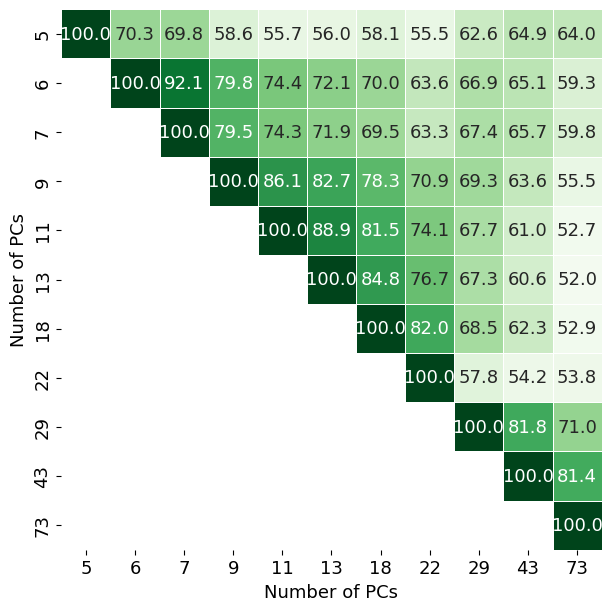

In [19]:
equivalent_predictions = np.zeros((len(nb_modes_array), len(nb_modes_array)))
for nb_modes_idx_1 in range(len(nb_modes_array)):
    for nb_modes_idx_2 in range(len(nb_modes_array)):
        mapping = np.zeros(len(all_centroids[nb_modes_idx_2]), dtype=int)
        for i in range(len(all_centroids[nb_modes_idx_1])):
            distances = np.linalg.norm(all_centroids[nb_modes_idx_1][i] - all_centroids[nb_modes_idx_2], axis=1)
            mapping[i] = np.argmin(distances)
        modified_y_pred = np.array([mapping[all_y_preds[nb_modes_idx_1][i]] for i in range(len(all_y_preds[nb_modes_idx_1]))])
        equivalent_predictions[nb_modes_idx_1, nb_modes_idx_2] = np.sum(modified_y_pred == all_y_preds[nb_modes_idx_2]) / len(all_y_preds[0]) * 100

plt.figure(figsize=(8, 6), constrained_layout=True)
mask = np.tril(np.ones_like(equivalent_predictions, dtype=bool), k=-1)
sns.heatmap(equivalent_predictions, annot=True, fmt=".1f", cmap="Greens", cbar=False, square=True, linewidths=0.5, vmin=np.min(equivalent_predictions), vmax=100, annot_kws={"fontsize":13}, xticklabels=nb_modes_array, yticklabels=nb_modes_array, mask=mask)
plt.xlabel("Number of PCs", fontsize=13) ; plt.ylabel("Number of PCs", fontsize=13) ; axs = plt.gca() ; axs.tick_params(labelsize=13)
plt.show()

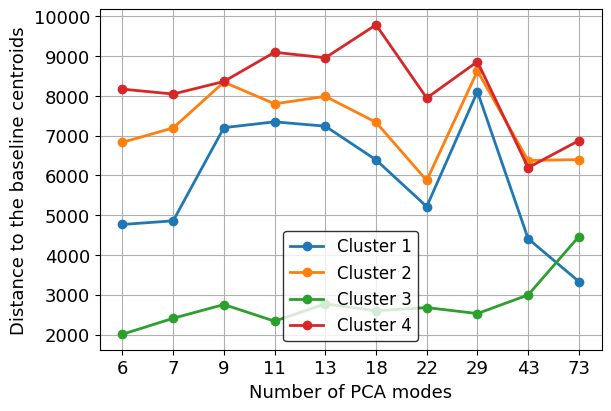

In [64]:
distance_array = np.zeros((len(nb_modes_array)-1, nb_clusters))
plt.figure(figsize=(6, 4), constrained_layout=True)
for nb_modes_idx in range(1, len(nb_modes_array)):
    mapping = np.zeros(len(all_centroids[0]), dtype=int)
    for i in range(len(all_centroids[0])):
        distances = np.linalg.norm(all_centroids[0][i] - all_centroids[nb_modes_idx], axis=1)
        mapping[i] = np.argmin(distances)

    for i in range(nb_clusters):
        distance_array[nb_modes_idx-1, i] = np.min(np.linalg.norm(all_centroids[0][i] - all_centroids[nb_modes_idx][mapping[i]]))

for i in range(nb_clusters):
    plt.plot(distance_array[:, i], marker="o", linewidth=2, label=f"Cluster {i+1}")
plt.grid() ; plt.legend(edgecolor='black', fontsize=12)
plt.xlabel("Number of PCA modes", fontsize=13) ; plt.ylabel("Distance to the baseline centroids", fontsize=13)
plt.xticks(ticks=np.arange(len(nb_modes_array)-1), labels=nb_modes_array[1:], fontsize=13) ; ax = plt.gca() ; ax.tick_params(labelsize=13)
plt.show()

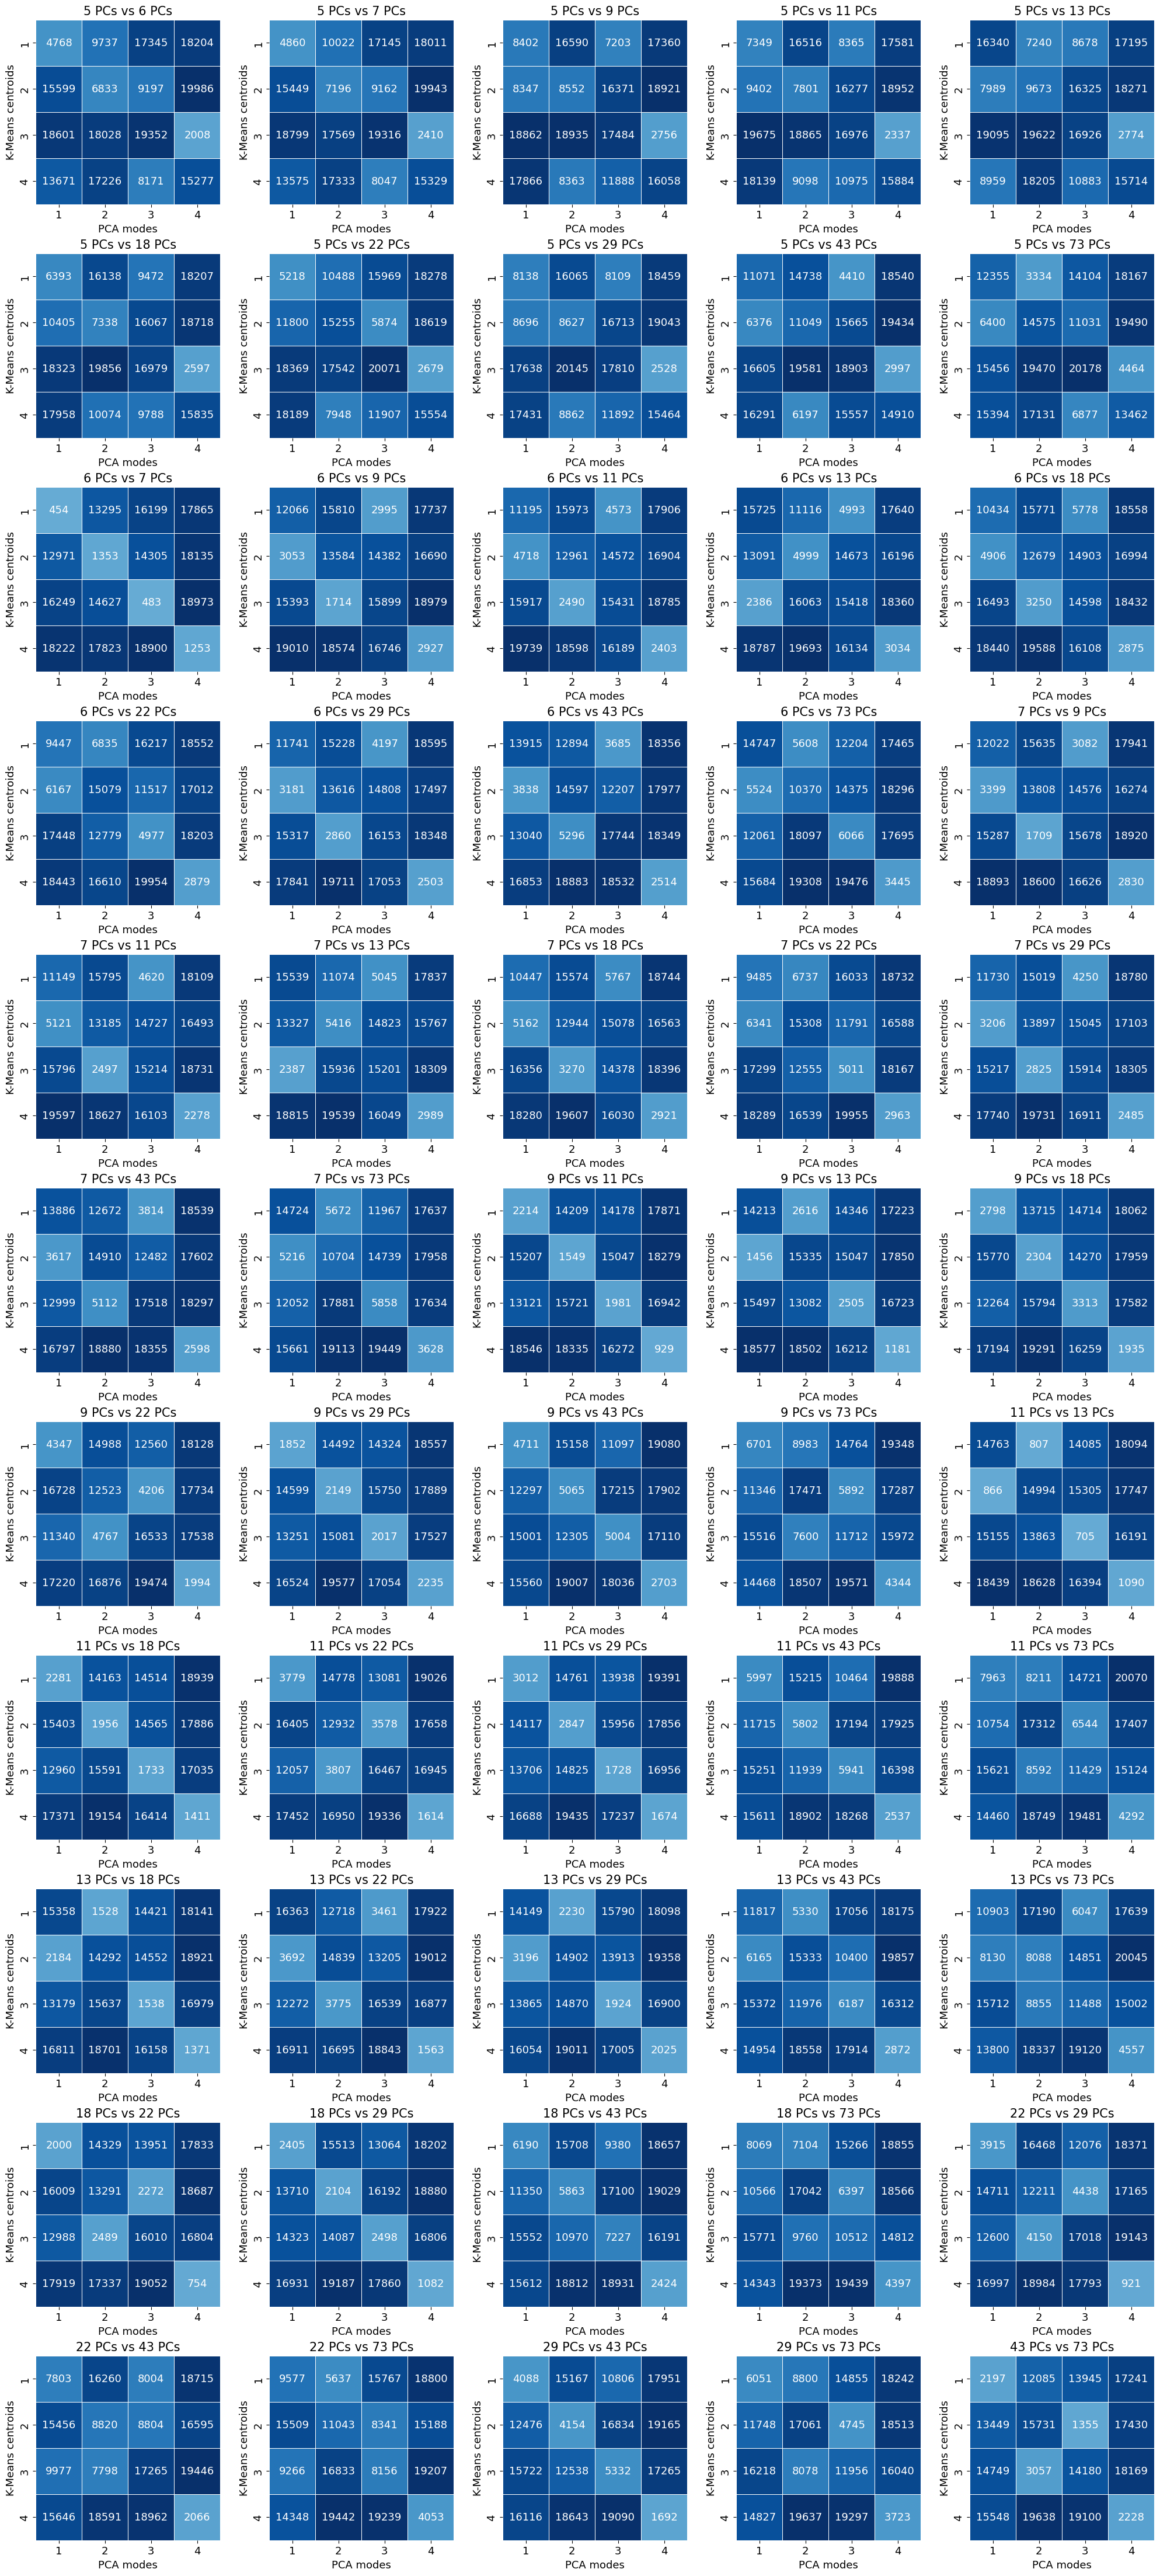

In [62]:
comparisons = []
for a in range(len(all_centroids)):
    for b in range(a+1, len(all_centroids)):
        comparisons.append((a, b))

ncols = 5 ; nrows = int(np.ceil(len(comparisons) / ncols))
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*4, nrows*4), constrained_layout=True)
for ax_idx in range(nrows*ncols):
    axis_to_plot = axs[ax_idx // ncols, ax_idx % ncols] if (nrows > 1) else axs[ax_idx % ncols]
    if (ax_idx >= len(comparisons)): axis_to_plot.set_visible(False) ; continue
    
    ### Compare the centroids of the two PCA modes ###
    (nb_modes_idx_1, nb_modes_idx_2) = comparisons[ax_idx]
    (nb_modes_1, nb_modes_2) = (nb_modes_array[nb_modes_idx_1], nb_modes_array[nb_modes_idx_2])
    axis_to_plot.set_title(f"{nb_modes_1} PCs vs {nb_modes_2} PCs", fontsize=15)

    distance = np.zeros((nb_clusters, nb_clusters))
    for i in range(nb_clusters):
        for j in range(nb_clusters):
            distance[i, j] = np.linalg.norm(all_centroids[nb_modes_idx_1][i] - all_centroids[nb_modes_idx_2][j])
   
    ax = sns.heatmap(distance, annot=True, fmt=".0f", cmap="Blues", cbar=False, ax=axis_to_plot, square=True, linewidths=0.5, center=0, annot_kws={"fontsize":13})
    axis_to_plot.set_xlabel("PCA modes", fontsize=13) ; axis_to_plot.set_ylabel("K-Means centroids", fontsize=13)
    axis_to_plot.set_xticklabels(np.arange(nb_clusters)+1, fontsize=13) ; axis_to_plot.set_yticklabels(np.arange(nb_clusters)+1, fontsize=13)

plt.show()

In [89]:
nb_clusters_array = np.arange(2, 15+1, 1) ; n_init = 100
all_log_likelihoods = [] ; gmm_full_models = []
all_scores = [] ; bic_values = [] ; aic_values = []
for nb_clusters in nb_clusters_array:
    start_time = time.time()
    gmm_full = GaussianMixture(n_components=nb_clusters, n_init=n_init, covariance_type="full").fit(data_for_clustering)
    end_time = time.time() ; print(f"GMM full algorithm with {nb_clusters} clusters performed in {end_time-start_time:.2f} seconds.")
    
    all_log_likelihoods.append(gmm_full.lower_bound_) ; gmm_full_models.append(gmm_full) ; all_scores.append(gmm_full.score(data_for_clustering))
    bic_values.append(gmm_full.bic(data_for_clustering)) ; aic_values.append(gmm_full.aic(data_for_clustering))

GMM full algorithm with 2 clusters performed in 9.81 seconds.
GMM full algorithm with 3 clusters performed in 31.63 seconds.
GMM full algorithm with 4 clusters performed in 27.16 seconds.
GMM full algorithm with 5 clusters performed in 39.83 seconds.
GMM full algorithm with 6 clusters performed in 52.24 seconds.
GMM full algorithm with 7 clusters performed in 68.38 seconds.
GMM full algorithm with 8 clusters performed in 88.76 seconds.
GMM full algorithm with 9 clusters performed in 103.45 seconds.
GMM full algorithm with 10 clusters performed in 143.53 seconds.
GMM full algorithm with 11 clusters performed in 140.62 seconds.
GMM full algorithm with 12 clusters performed in 154.14 seconds.
GMM full algorithm with 13 clusters performed in 196.43 seconds.
GMM full algorithm with 14 clusters performed in 237.36 seconds.
GMM full algorithm with 15 clusters performed in 254.32 seconds.


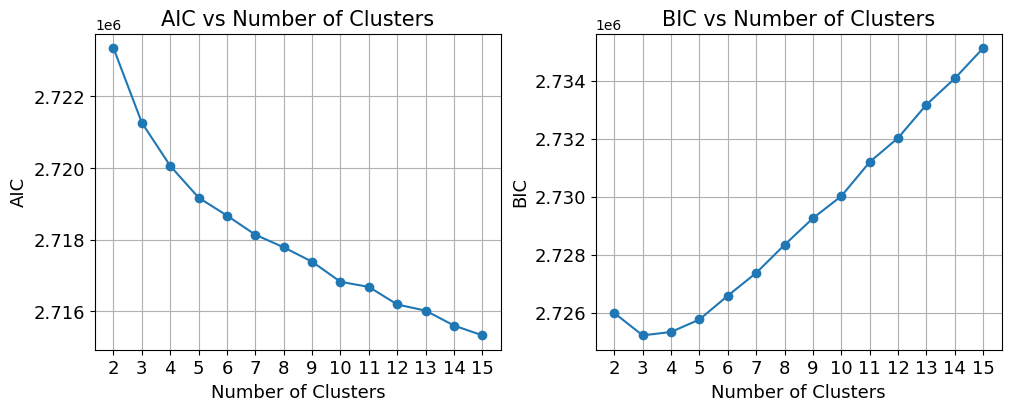

In [90]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)
axs[0].plot(nb_clusters_array, aic_values, marker='o', label='AIC')
axs[1].plot(nb_clusters_array, bic_values, marker='o', label='BIC')

axs[0].set_xticks(nb_clusters_array) ; axs[1].set_xticks(nb_clusters_array)
axs[0].set_title('AIC vs Number of Clusters', fontsize=15) ; axs[0].set_xlabel('Number of Clusters', fontsize=13) ; axs[0].set_ylabel('AIC', fontsize=13)
axs[1].set_title('BIC vs Number of Clusters', fontsize=15) ; axs[1].set_xlabel('Number of Clusters', fontsize=13) ; axs[1].set_ylabel('BIC', fontsize=13)

axs[0].tick_params(labelsize=13) ; axs[1].tick_params(labelsize=13) ; axs[0].grid() ; axs[1].grid()
plt.show()